### 統計學習與深度學習 (Fall, 2020)
### Homework 1 
B07902034 資工三 王昱凱

### 第一題 [myknn_regressor]
#### Q1.1 Create your myknn_regressor based on the skeleton.

以下為我實作的myknn_regressor架構，其中主要分為三個函式:
* init( ) 是用來定義這個class會使用到的參數，比較特別的是我會先判斷n_neighbors是否大於10，接著才對mean_type做定義
* fit( ) 是用來定義接下來prediction會使用到的data (x_train & y_train)
* predict( ) 是主要實作knn的函式，首先先計算跟所有neighbors之間的距離，接著排序並找出前$k$小的值，再來找出對應的$y_a$，如果mean_type是remove_outliers的話，則計算$y_a$的第一四分位數和第三四分位數並且將$y_a$的範圍限制在$[Q1 - 1.5 IQR, Q3 + 1.5 IQR]$，最後計算$y_a$的平均即為結果

In [6]:
import pickle
from sklearn import preprocessing
import numpy as np

class myknn_regressor():
    def __init__(self, n_neighbors = 10, mean_type = "equal_weight"):
        # initialize parameters
        self.n_neighbors = n_neighbors
        if n_neighbors < 10:
            self.mean_type = "equal_weight"
        else:
            self.mean_type = mean_type

    def fit(self, x_train, y_train):
        self.x = x_train
        self.y = y_train

    def predict(self, x_test):
        y_pred = np.zeros(len(x_test))
        for i in range(len(x_test)):
            # compute the distance
            dist = np.zeros(len(self.x))
            for j in range(len(self.x)):
                dist[j] = np.sum((x_test[i] - self.x[j]) ** 2)

            # find k nearnest neighbors
            min_dist = np.sort(dist)
            min_dist_list = list(map(list(dist).index, min_dist[:self.n_neighbors]))

            # find out y according to the values of k nearnest neighbors' distances
            y_a = np.zeros(len(min_dist_list))
            for j in range(len(min_dist_list)):
                y_a[j] = self.y[min_dist_list[j]]

            # remove outliers
            if self.mean_type == "remove_outliers":
                Q1 = np.quantile(y_a, 0.25)
                Q3 = np.quantile(y_a, 0.75)
                IQR = Q3 - Q1
                y_a = y_a[(y_a >= (Q1 - 1.5 * IQR)) & (y_a <= (Q3 + 1.5 * IQR))]

            # compute the mean
            y_pred[i] = np.sum(y_a) / len(y_a)
        return y_pred

#### Q1.2 & Q1.3
以下為我的實作方法，首先先讀取data並對其做標準化，接著分別按照equal_weight和remove_outliers兩種case做prediction，最後再計算RMSE並印出RMSE和prediction的前20項

In [6]:
#Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1

if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

myknn = myknn_regressor(20, "equal_weight")
myknn.fit(X_train, Y_train)
ypred = myknn.predict(X_test)
RMSE = np.sqrt(np.sum((ypred - Y_test) ** 2) / len(ypred))

print("n_neighbors = 20, mean_type = equal_weight:")
print("RMSE = ", RMSE)
print("first 20 prediction = \n", ypred[:20])

print()

myknn = myknn_regressor(20, "remove_outliers")
myknn.fit(X_train, Y_train)
ypred = myknn.predict(X_test)
RMSE = np.sqrt(np.sum((ypred - Y_test) ** 2) / len(ypred))

print("n_neighbors = 20, mean_type = remove_outliers:")
print("RMSE = ", RMSE)
print("first 20 prediction = \n", ypred[:20])

n_neighbors = 20, mean_type = equal_weight:
RMSE =  10.25126451549596
first 20 prediction = 
 [1993.35 1993.8  2000.65 1991.5  1992.8  1998.5  1988.1  1991.65 2002.25
 2003.   2000.5  1998.65 1995.55 1997.2  1995.05 1997.4  1992.15 2000.45
 2003.2  1995.75]

n_neighbors = 20, mean_type = remove_outliers:
RMSE =  10.212572466080376
first 20 prediction = 
 [1993.35       1993.8        2000.65       1992.73684211 1992.8
 2000.         1988.1        1991.65       2002.25       2003.94736842
 2000.5        2000.94444444 1995.55       1997.2        1998.61111111
 1997.4        1992.15       2003.83333333 2003.2        1995.75      ]


### 第二題 [Tuning the Hyper-parameter]
以下為我實作的方法，分別依照三種cases利用迴圈對不同的$k$值做prediction，然後將結果儲存在list裡，最後再利用matplotlib將折線圖畫出來

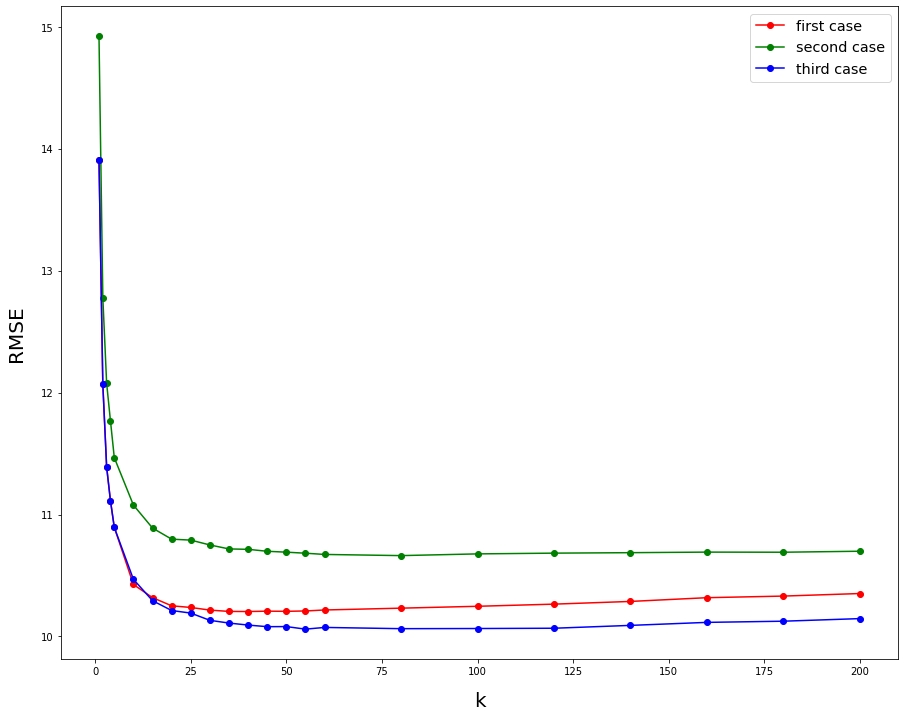

In [12]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
# standardize feature values
X_train_sd = xscaler.transform(msd_data['X_train'])
X_test_sd = xscaler.transform(msd_data['X_test'])

X_train = msd_data['X_train']
X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

k = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 100, 120, 140, 160, 180, 200]
RMSE_1 = []
RMSE_2 = []
RMSE_3 = []

# predict and compute rmse for three different cases
for i in range(len(k)):
    knn_1 = KNeighborsRegressor(n_neighbors=k[i])
    knn_1.fit(X_train_sd, Y_train)
    ypred_1 = knn_1.predict(X_test_sd)
    RMSE_1.append(np.sqrt(np.sum((ypred_1 - Y_test) ** 2) / len(ypred_1)))

    knn_2 = KNeighborsRegressor(n_neighbors=k[i])
    knn_2.fit(X_train, Y_train)
    ypred_2 = knn_2.predict(X_test)
    RMSE_2.append(np.sqrt(np.sum((ypred_2 - Y_test) ** 2) / len(ypred_2)))
    
    myknn = myknn_regressor(k[i], "remove_outliers")
    myknn.fit(X_train_sd, Y_train)
    ypred_3 = myknn.predict(X_test_sd)
    RMSE_3.append(np.sqrt(np.sum((ypred_3 - Y_test) ** 2) / len(ypred_3)))

# plot the curves of three different cases
plt.figure(figsize=(15,12))
plt.plot(k, RMSE_1,'o-',color = 'r', label = 'first case')
plt.plot(k, RMSE_2,'o-',color = 'g', label = 'second case')
plt.plot(k, RMSE_3,'o-',color = 'b', label = 'third case')
plt.xlabel("k", fontsize=20, labelpad = 15)
plt.ylabel("RMSE", fontsize=20, labelpad = 15)
plt.legend(fontsize='x-large')
plt.show()

此為我得到的結果，其中紅色為case 1，綠色為case 2，藍色為case 3，透過圖片可以觀察出case 2的結果比起另外兩者差上不少，其主要原因是標準化的有無，由於資料中每個不同的feature都是以數值來表示的，然而他們的數值範圍和分布狀況等等並不完全相同，因此進行標準化能讓資料都落在一定範圍內，對於做prediction有很大的幫助，至於case 1和case 3，當$k<10$時是完全重疊的，因為實作myknn_regressor時有加入限制，當$k<10$時mean_type只能為equal weight，而當$k=10$時，case 1的結果比case 3來的好，原因可能是remove outliers後取的neighbors數量不夠多，導致預測結果不夠好，但是當$k$足夠大時，很明顯可以觀察到remove outliers後得到的結果是最好的，因此移除一些比較極端的值後再取平均對於prediction是有幫助的

### 第三題 [Lasso Regression]
#### Q3.1 基於本題給的$L$，推導新的Coordinate Descent with Soft Thresholding公式
$$L = \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - w_0)^2 + \lambda [\sum_{j=1}^{M} |w_j|]$$
<br>
<br>
$$\frac{∂L}{∂w_j} = \frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - w_0)(-x_{i,j}) + \lambda sgn(w_j) = 0$$
<br>
<br>
$$\frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{w}^T_{-j}  \mathbf{x}_{i,-j} - w_0 - w_j x_{i,j})(-x_{i,j}) + \lambda sgn(w_j) = 0$$
<br>
<br>
$$\frac{1}{n} [ \sum_{i=1}^n (y_i - \mathbf{w}^T_{-j}  \mathbf{x}_{i,-j} - w_0)(-x_{i,j}) + w_j \sum_{i=1}^n (x_{i,j})^2 ] + \lambda sgn(w_j) = 0$$
<br>
<br>
$$w_j = \frac{[ \sum_{i=1}^n (y_i - \mathbf{w}^T_{-j}  \mathbf{x}_{i,-j} - w_0) x_{i,j} - n \lambda sgn(w_j) ]}{\sum_{i=1}^n(x_{i,j})^2}$$
<br>
<br>
$$w_j^* = \frac{[ \sum_{i=1}^n (y_i - \mathbf{w}^T_{-j}  \mathbf{x}_{i,-j} - w_0) x_{i,j} ]}{\sum_{i=1}^n(x_{i,j})^2}$$
<br>
<br>
$$w_j = \begin{cases} w_j^* - \frac{n \lambda}{\sum_{i=1}^n(x_{i,j})^2}, & \text {if $w_j^* - \frac{n \lambda}{\sum_{i=1}^n(x_{i,j})^2} > 0$} \\ w_j^* + \frac{n \lambda}{\sum_{i=1}^n(x_{i,j})^2}, & \text {if $w_j^* + \frac{n \lambda}{\sum_{i=1}^n(x_{i,j})^2} < 0$} \\ 0, & \text {otherwise} \end{cases}$$

#### Q3.2 使用給定個骨架建構你的mylasso
以下為我實作的mylasso架構，其中主要分為三個函式:
* init( )是用來定義mylasso這個class的參數
* fit( )是主要用來做training的函式，首先依照keep_traindata來決定是否儲存資料，接著先利用ridge regression來計算出起始的$w$，接著就按照上面所推導出的公式來進行coordinate descent with soft thresholding直到收斂或完成所有iteration，而我也有把$w_0$也就是bias term拿來做coordinate descent
* predict( )是將讀入的testing data和用fit( )得到的$w$來做prediction

In [7]:
import numpy as np
import pickle
from sklearn import preprocessing

class mylasso():
    def __init__(self, lamcoef = 0.1, max_iter=1000, tol=1e-6, const_regu = False):
        # initialize parameters
        self.lamcoef = lamcoef
        self.max_iter = max_iter
        self.tol = tol
        self.const_regu = const_regu
 
    def fit(self, x_train, y_train, winit = "ridge", keep_traindata = True, verbose = False):
        if keep_traindata:
          self.x_train = x_train

        # decide an initial w by Ridge Regression
        w = np.dot(np.linalg.inv(0.1 * np.identity(x_train.shape[1]) + np.dot(x_train.transpose(), x_train)), np.dot(x_train.transpose(), y_train))
        
        # compute the loss function L or L'
        if self.const_regu:
            L = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(w))
        else:
            L = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(np.delete(w, 0, 0)))

        self.w = w
        L_min = L

        for i in range(self.max_iter):    
            # implement coordinate descent with soft thresholding
            for j in range(len(w)):
                w_star = np.sum((y_train - np.dot(np.delete(x_train, j, 1), np.delete(w, j, 0))) * x_train[:, j]) / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                if w_star - len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j])) > 0:
                    w[j] = w_star - len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                elif w_star + len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j])) < 0:
                    w[j] = w_star + len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                else:
                    w[j] = 0
            
            # compute the loss after an iteration
            if self.const_regu:
                L_new = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(w))
            else:
                L_new = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(np.delete(w, 0, 0)))

            # update w with the lowest loss
            if L_new < L_min:
                self.w = w
                L_min = L_new

            # compare the loss before and after an iteration
            if np.abs(L - L_new) < self.tol:
                break

            L = L_new

        # compute RMSE
        ypred = np.dot(x_train, self.w)
        RMSE = np.sqrt(np.sum((ypred - y_train) ** 2) / len(ypred))

        # compute MAE
        MAE = np.sum(np.abs(ypred - y_train)) / len(ypred)

        # compute number of nonzero weights
        nonzero_w = 0
        for i in range(len(self.w)):
            if i == 0:
                continue
            if self.w[i] != 0:
                nonzero_w += 1

        print("Training Loss = ", L_min)
        print("Train RMSE = ", RMSE)
        print("Train MAE = ", MAE)
        print("Intercept = ", self.w[0])
        print("Feature Weights = \n", self.w[1:])
        print("Number of Nonzero Weights = ", nonzero_w)
 
    def predict(self, x_test):
        y_pred = np.dot(x_test, self.w)
        return y_pred

#### Q3.3 & Q3.4

以下為我實作的方法，先讀取資料並標準化，接著將training data傳進mylasso做training，由於我在上面架構中的fit函式裡有加入印出training loss, RMSE, MAE, intercept, feature weights, number of nonzero weights這些資訊，因此執行fit( )就會自動印出，最後只要再印出prediction的結果和計算出的RMSE和MAE即可

In [8]:
np.set_printoptions(suppress=True)
 
# Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
# standardize feature values
X_train_sd = xscaler.transform(msd_data['X_train'])
X_test_sd = xscaler.transform(msd_data['X_test'])

# add a column with all ones
const_train = np.ones((X_train_sd.shape[0], 1))
X_train_sd = np.concatenate((const_train, X_train_sd), axis=1)
const_test = np.ones((X_test_sd.shape[0], 1))
X_test_sd = np.concatenate((const_test, X_test_sd), axis=1)
 
# outcome values
Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

mlo = mylasso(lamcoef = 0.1)
mlo.fit(X_train_sd, Y_train)
ypred = mlo.predict(X_test_sd)

RMSE = np.sqrt(np.sum((ypred - Y_test) ** 2) / len(ypred))
MAE = np.sum(np.abs(ypred - Y_test)) / len(ypred)
print()
print("first 5 prediction = ", ypred[:5])
print("Test RMSE = ", RMSE)
print("Test MAE = ", MAE)

Training Loss =  49.893404109953586
Train RMSE =  9.720013505274403
Train MAE =  7.003889367216193
Intercept =  1998.1660000000002
Feature Weights = 
 [ 4.6518551  -2.45673153 -1.06195885  0.         -0.34275054 -2.94854329
  0.         -0.39970268 -0.42653866  0.         -0.23498651 -0.39491058
  0.50307719  0.         -0.34207893  0.61674589  0.15722753  0.43489925
  0.43595375  1.12941661  0.40663481  0.          1.77743607  0.
 -0.16842728  0.07833529  0.66391172  0.01297938  0.15350723  0.
 -0.21762074 -0.22189107  0.         -0.0027548  -0.01707674 -0.2599464
  0.          0.28969362  0.34893387  0.         -0.26112569 -0.14488702
 -0.00995271  0.03497723 -0.03984338  0.          0.00299383 -0.17804306
  0.          0.06494382  0.27076506  0.          0.          0.
  0.          0.         -0.63813223  0.23761428 -0.19016387  0.
 -0.18875525  0.         -0.13590668  0.0612754  -0.26619017  0.
  0.          0.         -0.03099184  0.         -0.19276517  0.01221358
  0.20735199  

#### Q3.5
由於在此題中需要列出training loss, number of nonzero weights, average weight size, train rmse，因此我修改mylasso的fit函式來讓fit會回傳這些資訊，其餘的部分則完全相同，而接下來就一樣是讀取資料，並且以迴圈的方式傳進不同的$\lambda$再做training，最後再將這些結果畫成折線圖，其中我將train rmse和test rmse放在同一張圖中的原因是他們兩者的數值範圍是較為接近的，而其他資料彼此間的範圍差異較大，因此我就個別分開畫出來，才較為容易觀察

Training Loss =  [46.57046065 46.58737862 46.6084608  46.77466897 46.97687564 48.41863988
 49.89340411 56.50068821 60.38932372 63.49213128]


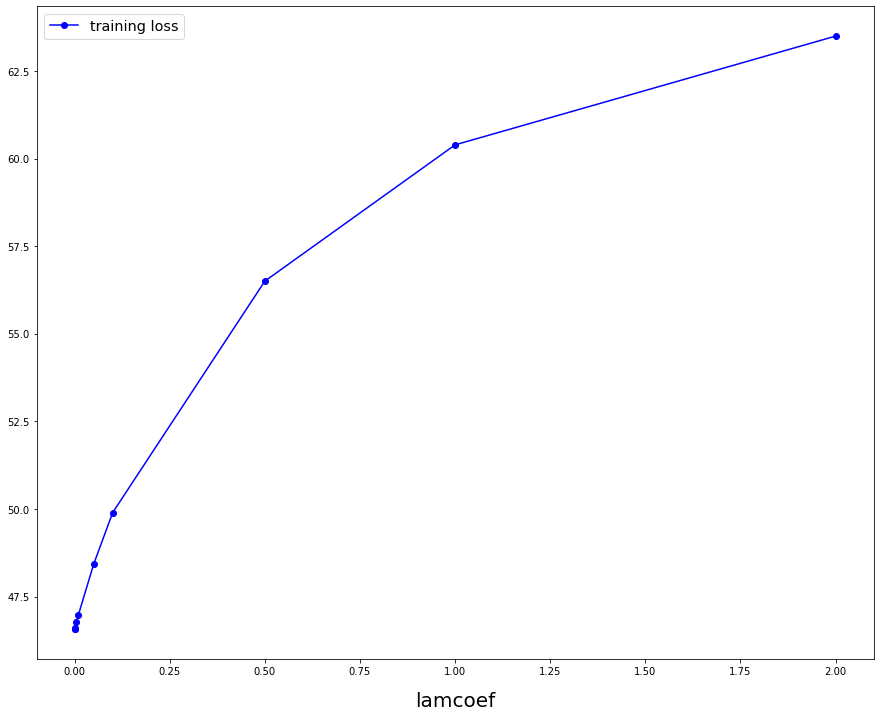

Number of Nonzero Weights =  [90. 90. 90. 89. 87. 76. 59. 16.  4.  1.]


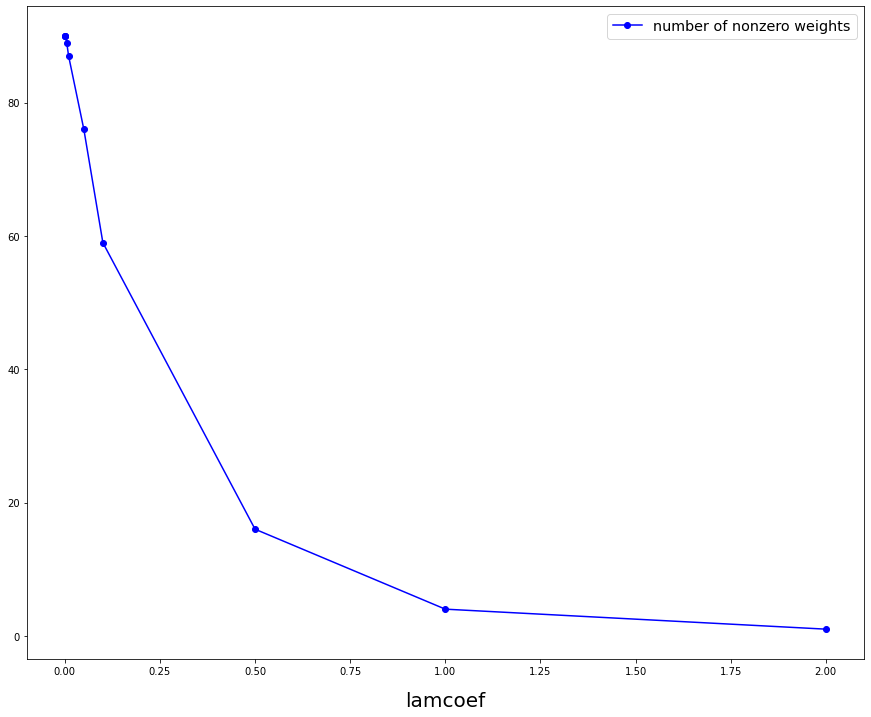

Average Weight Size =  [0.47057706 0.46949461 0.46790094 0.45575298 0.4429032  0.36397709
 0.29489698 0.12003119 0.04217497 0.00426559]


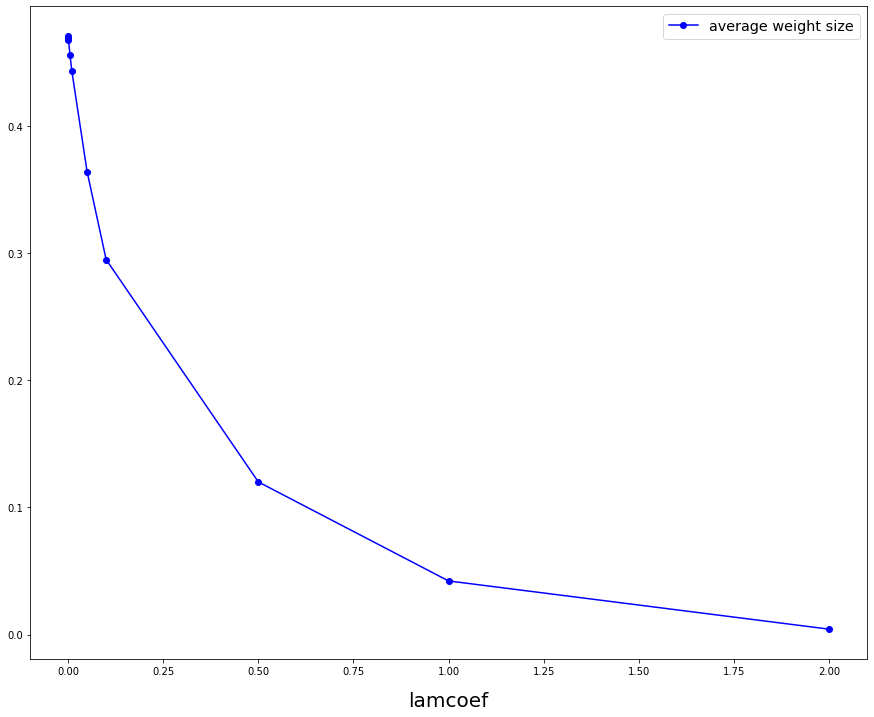

Train RMSE =  [ 9.65051558  9.65051826  9.65052845  9.65086319  9.65176282  9.67271864
  9.72001351 10.10933079 10.63894512 11.20038619]
Test RMSE =  [ 9.64435445  9.64408879  9.64354554  9.64010943  9.63650189  9.62705471
  9.6500763  10.02119468 10.5480607  11.14107316]


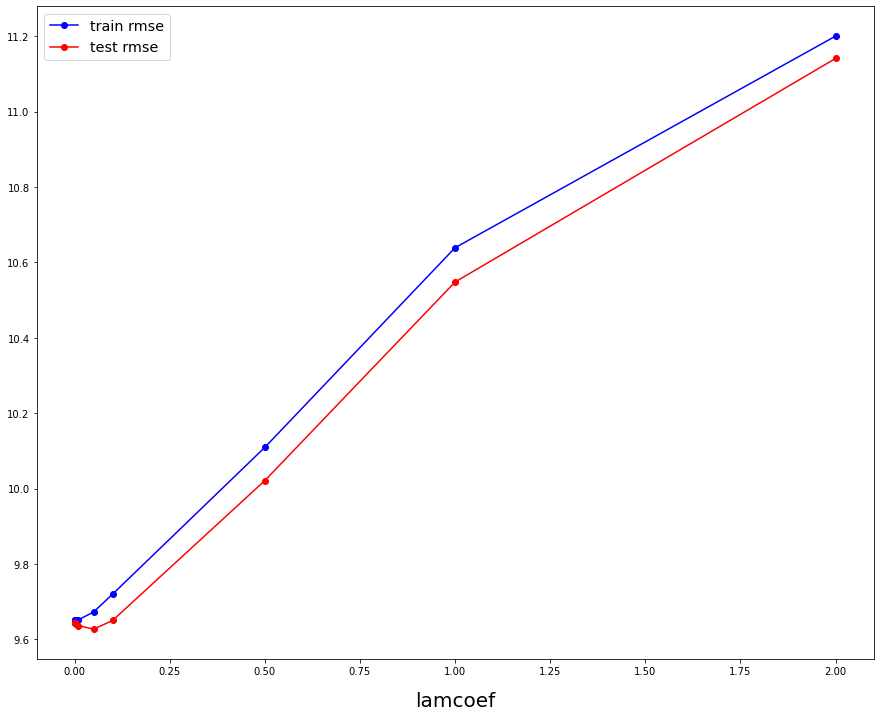

In [11]:
import numpy as np
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt

class mylasso():
    def __init__(self, lamcoef = 0.1, max_iter=1000, tol=1e-6, const_regu = False):
        # initialize parameters
        self.lamcoef = lamcoef
        self.max_iter = max_iter
        self.tol = tol
        self.const_regu = const_regu
 
    def fit(self, x_train, y_train, winit = "ridge", keep_traindata = True, verbose = False):
        if keep_traindata:
          self.x_train = x_train

        # decide an initial w by Ridge Regression
        w = np.dot(np.linalg.inv(0.1 * np.identity(x_train.shape[1]) + np.dot(x_train.transpose(), x_train)), np.dot(x_train.transpose(), y_train))
        
        # compute the loss function L or L'
        if self.const_regu:
            L = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(w))
        else:
            L = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(np.delete(w, 0, 0)))

        self.w = w
        L_min = L

        for i in range(self.max_iter):
            if verbose:
                print("the " + str(i) + " iteration, the loss = " + str(L))      
            # implement coordinate descent with soft thresholding
            for j in range(len(w)):
                w_star = np.sum((y_train - np.dot(np.delete(x_train, j, 1), np.delete(w, j, 0))) * x_train[:, j]) / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                if w_star - len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j])) > 0:
                    w[j] = w_star - len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                elif w_star + len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j])) < 0:
                    w[j] = w_star + len(y_train) * self.lamcoef / np.sum(np.dot(x_train[:, j].transpose(), x_train[:, j]))
                else:
                    w[j] = 0
            
            # compute the loss after an iteration
            if self.const_regu:
                L_new = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(w))
            else:
                L_new = np.sum(np.power(y_train - np.dot(x_train, w), 2))/2/len(y_train) + self.lamcoef*np.sum(np.abs(np.delete(w, 0, 0)))

            # update w with the lowest loss
            if L_new < L_min:
                self.w = w
                L_min = L_new

            # compare the loss before and after an iteration
            if np.abs(L - L_new) < self.tol:
                break

            L = L_new

        # compute RMSE
        ypred = np.dot(x_train, self.w)
        RMSE = np.sqrt(np.sum((ypred - y_train) ** 2) / len(ypred))

        # compute number of nonzero weights and average weight size
        nonzero_w = 0
        for i in range(len(self.w)):
            if i == 0:
                continue
            if self.w[i] != 0:
                nonzero_w += 1
        mean_w = np.sum(np.abs(self.w[1:])) / len(self.w[1:])

        return L_min, nonzero_w, mean_w, RMSE


    def predict(self, x_test):
        y_pred = np.dot(x_test, self.w)
        return y_pred

np.set_printoptions(suppress=True)

# Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
# standardize feature values
X_train_sd = xscaler.transform(msd_data['X_train'])
X_test_sd = xscaler.transform(msd_data['X_test'])

# add a column with all ones
const_train = np.ones((X_train_sd.shape[0], 1))
X_train_sd = np.concatenate((const_train, X_train_sd), axis=1)
const_test = np.ones((X_test_sd.shape[0], 1))
X_test_sd = np.concatenate((const_test, X_test_sd), axis=1)

# outcome values
Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

lam = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
train_loss = np.zeros(len(lam))
nonzero_w = np.zeros(len(lam))
mean_w = np.zeros(len(lam))
train_rmse = np.zeros(len(lam))
test_rmse = np.zeros(len(lam))
for i in range(len(lam)):
    mlo = mylasso(lamcoef = lam[i])
    train_loss[i], nonzero_w[i], mean_w[i], train_rmse[i] = mlo.fit(X_train_sd, Y_train)
    ypred = mlo.predict(X_test_sd)
    test_rmse[i] = np.sqrt(np.sum((ypred - Y_test) ** 2) / len(ypred))

# print and plot the results after training
print("Training Loss = ", train_loss)
plt.figure(figsize=(15,12))
plt.plot(lam, train_loss,'o-',color ='b', label='training loss')
plt.xlabel("lamcoef", fontsize=20, labelpad = 15)
plt.legend(fontsize='x-large')
plt.show()

print("Number of Nonzero Weights = ", nonzero_w)
plt.figure(figsize=(15,12))
plt.plot(lam, nonzero_w,'o-',color='b', label='number of nonzero weights')
plt.xlabel("lamcoef", fontsize=20, labelpad = 15)
plt.legend(fontsize='x-large')
plt.show()

print("Average Weight Size = ", mean_w)
plt.figure(figsize=(15,12))
plt.plot(lam, mean_w,'o-',color='b', label='average weight size')
plt.xlabel("lamcoef", fontsize=20, labelpad = 15)
plt.legend(fontsize='x-large')
plt.show()

print("Train RMSE = ", train_rmse)
print("Test RMSE = ", test_rmse)
plt.figure(figsize=(15,12))
plt.plot(lam, train_rmse,'o-',color='b', label='train rmse')
plt.plot(lam, test_rmse,'o-',color='r', label='test rmse')
plt.xlabel("lamcoef", fontsize=20, labelpad = 15)
plt.legend(fontsize='x-large')
plt.show()

從這些圖中可以觀察到，當$\lambda$越小，training loss和rmse基本上越小，可以看出小一點的$\lambda$有較好的預測結果，而從number of nonzero weights和average weight size這兩張圖片可以觀察出$\lambda$越大，這兩者會越小，其原因可以從推導出的公式得知，當$\lambda$越大，$w_j$在更新時越容易被更新為0，因此number of nonzero weights會變少，也就是為0的weight變多，average weight size也就隨之變小，最後透過rmse的結果可以發現當$\lambda = 0.05$時test rmse有最小值，因此最終可以選來做為模型的參數